# Imports


In [174]:
import warnings
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder

In [2]:
warnings.simplefilter(action="ignore")

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 
  

# wrangle function


In [6]:
# Create wrangle function based on the cleaning done in data-cleaning file
def wrangle(source):
    df = source
    
    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    # drop all field with "?" to nan
    df.replace("?", np.nan, inplace=True)
    
    #Drop all rows with null values
    df.dropna(inplace=True)
    
    #Drop all columns not needed for analysis
    df.drop(columns=["fnlwgt", "education-num", "capital-gain", "capital-loss"], inplace=True)
    
    # limit age to 80 years
    df = df[df["age"] <= 80]
    
    # standardize the target column
    df["income"] = df["income"].str.replace(".","", regex=False)
    
    # turn target column to binary column
    income_map = {"<=50K":1, ">50K":0}
    df["income"] = df["income"].map(income_map)
    
    return df

In [7]:
# create dataframe
df = wrangle(adult.data.original)

In [8]:
# Check first five values of data frame
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,1
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,1
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,1
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,1
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,1


#  Split


In [10]:
#split target and features 
target = "income"

X = df.drop(columns=target)
y = df[target]

In [12]:
# Split train and test set
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [14]:
# Split train and val set
X_train,X_val,y_train,y_val = train_test_split(X_train ,y_train , test_size=0.2, random_state=42)

In [16]:
print(f"""
X_train: {X_train.shape}, y_train: {y_train.shape}
X_test: {X_test.shape}, y_test: {y_test.shape}
X_val: {X_val.shape}, y_val: {y_val.shape}
""")


X_train: (28851, 10), y_train: (28851,)
X_test: (9017, 10), y_test: (9017,)
X_val: (7213, 10), y_val: (7213,)



# Baseline

In [23]:
#calculate y_train value counts
baseline_acc = y_train.value_counts(normalize = True).max()
baseline_acc

0.7522442896260095

# Trainining, Validation and Testing

In [31]:
model= make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state = 42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital-status', 'occupation',
                                      'relationship', 'race', 'sex',
                                      'native-country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping': Private             1
Local-gov           2
Self-emp-inc        3
Self-emp-not-inc    4
Federal-gov         5
State-gov           6
Without-pay         7
NaN                -2
dtype: int64},
                                         {'col': 'education',
                                          'data_type': dty...
Trinadad&Tobago               16
Puerto-Rico                   17
El-Salvador                   18
Greece                        19
Germany                       20
Portugal                      21
China     

In [37]:
# Predict target using the train data
y_train_pred = model.predict(X_train)

In [38]:
accuracy_score(y_train, y_train_pred)

0.9667949117881529

In [40]:
#predict X_val
y_val_pred = model.predict(X_val)

In [41]:
accuracy_score(y_val, y_val_pred)

0.775960072092056

### """Since validation accuracy is just a little better than the baseline, the line of best fit should be found and there should be remodelling""" 

In [214]:
# get the depth of tree before training completed
max_depth = model["decisiontreeclassifier"].get_depth()

In [121]:
# initialise a list to store train and validation sets
train_acc = []
val_acc = []

#loop through to find the perfect fit
for d in range(1,max_depth):
    # create and fit model
    model= make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(max_depth=d, random_state = 42))
    model.fit(X_train, y_train)
    
    #predict the value for train and validation sets
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    
    #append the accuracy scores to the initialised lists
    train_acc.append(accuracy_score(y_train, pred_train))
    val_acc.append(accuracy_score(y_val, pred_val))

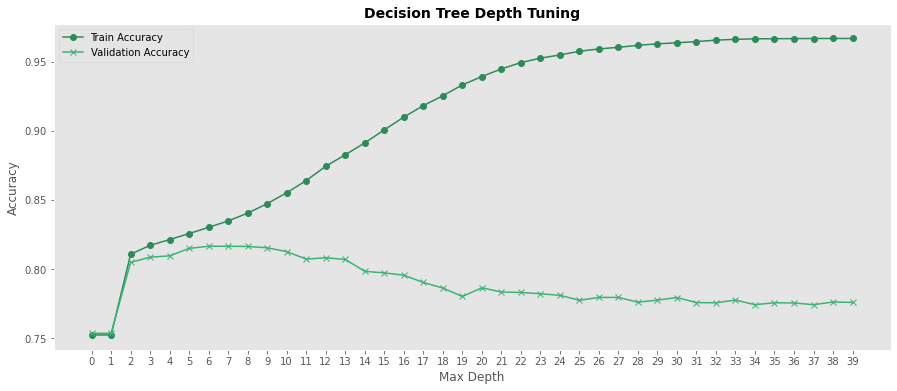

In [212]:

# Plot a line graph showing predicted value for train and validation
plt.figure(figsize=(15, 6))
plt.plot(train_acc, label="Train Accuracy", marker='o', color='seagreen')
plt.plot(val_acc, label="Validation Accuracy", marker='x', color='mediumseagreen')
plt.xlabel("Max Depth", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Decision Tree Depth Tuning", fontsize=14, fontweight='bold')
plt.xticks(range(len(train_acc)))  
plt.legend()
plt.grid(False) 

plt.show()


In [123]:
# Determine the best depth
best_depth = 0
bd = {}
for i,v in enumerate(val_acc):
    if v > best_depth:
        bd[i] = v


In [126]:
# Sort the bd dictionary by accuracy in descending order
sorted_bd = list(sorted(bd.items(), key=lambda item: item[1], reverse=True))

print(sorted_bd[0])

(6, 0.8164425343130459)


In [144]:
# Retrain model using the best depth
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=7, random_state=42)
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['workclass', 'education',
                                      'marital-status', 'occupation',
                                      'relationship', 'race', 'sex',
                                      'native-country'],
                                mapping=[{'col': 'workclass',
                                          'data_type': dtype('O'),
                                          'mapping': Private             1
Local-gov           2
Self-emp-inc        3
Self-emp-not-inc    4
Federal-gov         5
State-gov           6
Without-pay         7
NaN                -2
dtype: int64},
                                         {'col': 'education',
                                          'data_type': dty...
Trinadad&Tobago               16
Puerto-Rico                   17
El-Salvador                   18
Greece                        19
Germany                       20
Portugal                      21
China     

In [169]:
#Calculate accuracy score on train data
acc_train = round(model.score(X_train, y_train), 4)
acc_train

0.8301

In [170]:
#Calculate accuracy score on test data
acc_test = round(model.score(X_test, y_test), 4)
acc_test

0.8233

In [171]:
#Calculate accuracy score on val data
acc_val = round(model.score(X_val, y_val), 4)
acc_val

0.8164

# Communicate Result

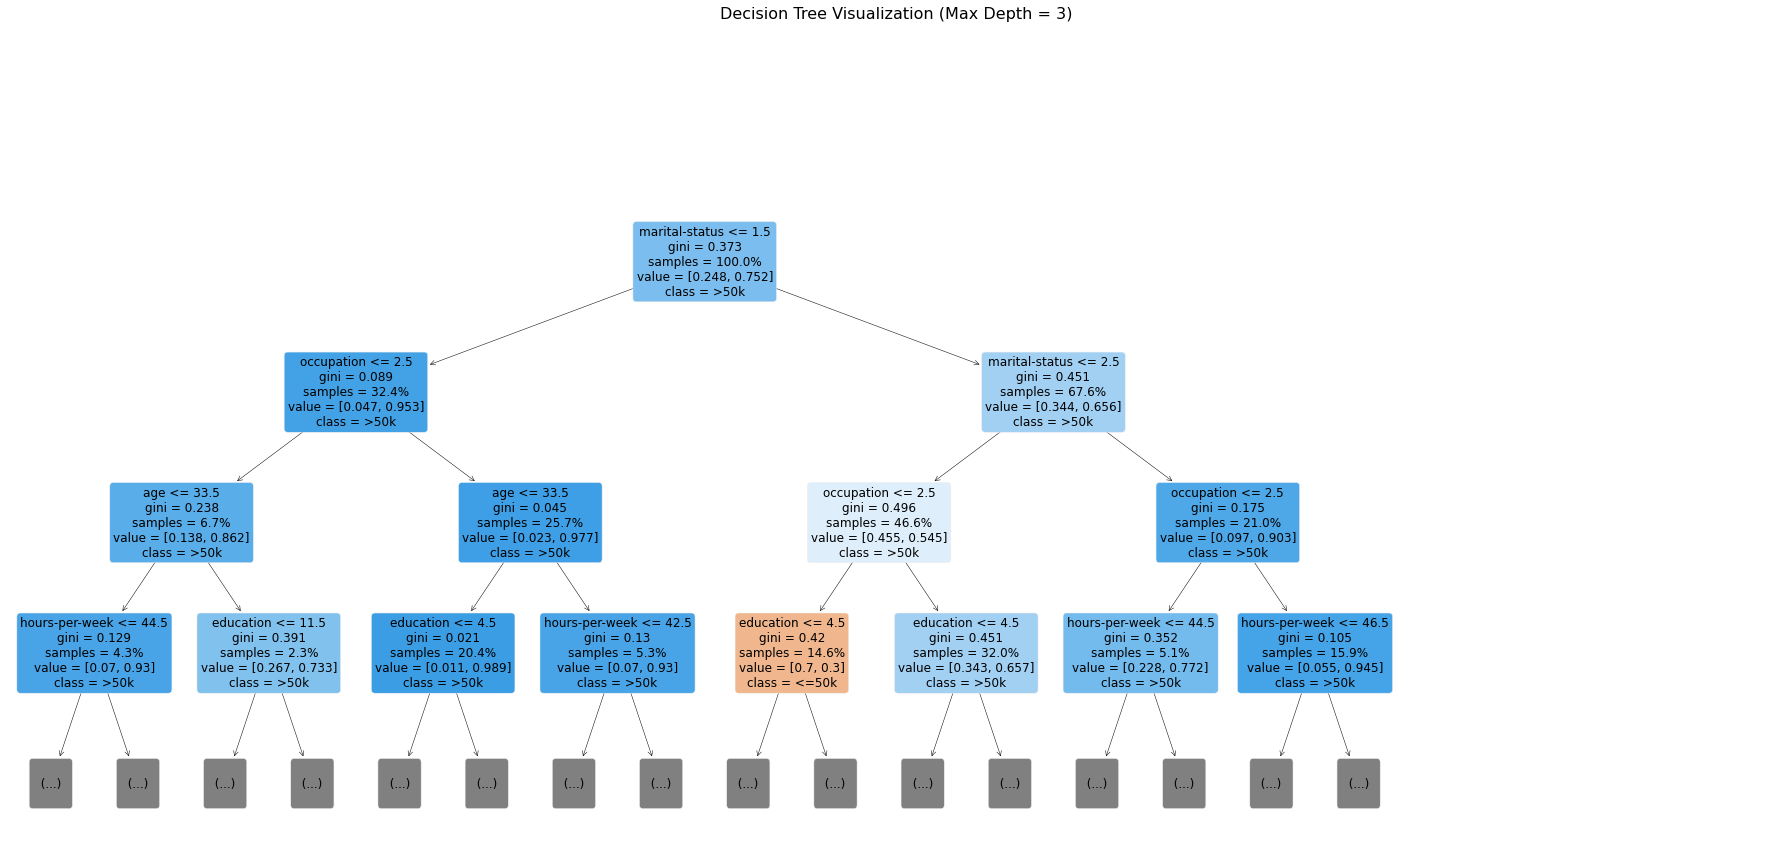

In [200]:
# Plot the decision tree

plt.style.use("seaborn-muted")
plt.subplots(figsize=(25, 12))
plot_tree(
    model["decisiontreeclassifier"], 
    filled=True, 
    feature_names=X_train.columns, 
    class_names=["<=50k", ">50k"], 
    rounded=True, 
    proportion=True,
    max_depth=3,
    fontsize=12)

plt.title("Decision Tree Visualization (Max Depth = 3)", fontsize=16)
plt.tight_layout()  # Prevents label cutoff
plt.show()

In [177]:
importances = model["decisiontreeclassifier"].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp

native-country    0.001320
race              0.001558
workclass         0.002188
relationship      0.006817
sex               0.008583
hours-per-week    0.045689
age               0.067125
education         0.103699
occupation        0.219821
marital-status    0.543200
dtype: float64

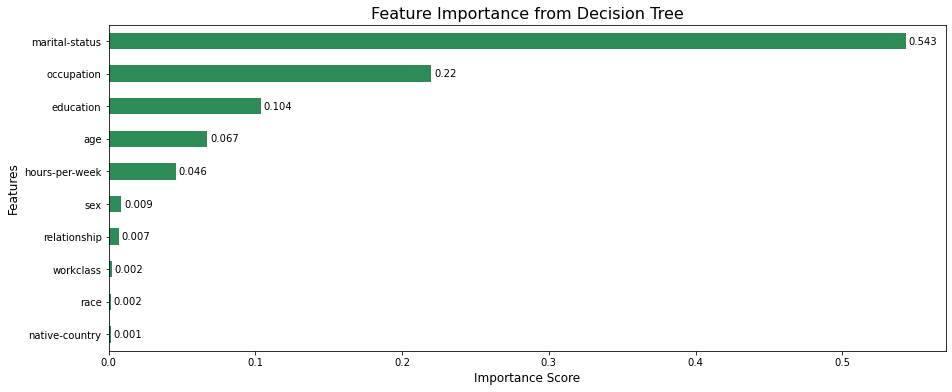

In [187]:
# Create horizontal bar chart
plt.figure(figsize=(15, 6))
feat_imp.plot(kind="barh", color="seagreen") 
plt.title("Feature Importance from Decision Tree", fontsize=16)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add value labels
for h, v in enumerate(feat_imp.values):
    plt.text(v + 0.002, h, str(round(v, 3)), va="center", ha="left", fontsize=10)


plt.show()